# 人脸关键点检测之PFLD

人脸关键点检测是一个非常核心的算法业务，其在许多场景中都有应用。比如我们常用的换脸、换妆、人脸识别等2C APP中的功能，都需要先进行人脸关键点的检测，然后再进行其他的算法业务处理；在一些2B的业务场景中，如疲劳驾驶中对人脸姿态的估计，也可以先进行人脸关键点的检测，然后再通过2D到3D的估计，最后算出人脸相对相机的姿态角。

PFLD算法可以以很小的网络模型在常见的人脸关键点检测数据集上得出不错的结果。

![show_images](images/result1.png)

## 模型简介

在模型设计上，PFLD的骨干网络没有采用VGG16、ResNet等大模型，而是采用了MobileNet。但是为了增加模型的表达能力，对MobileNet的输出特征进行了结构上的修改(TODO:进行了什么修改？)。同时，网络包含主干网络和辅助网络两部分，辅助网络主要用于在训练时预测人脸姿态，从而提高定位精度。（TODO：对应图例进行整体介绍解析）

### 网络特点

如论文中的表格所示，TODO：解析XXX。

![show_images](images/speed.png)

1. 算法对嵌入式设备非常友好，在骁龙845的芯片中效率可达140fps。
2. 另外模型大小较小，仅2.1MB。
3. NME、ION和IPN等指标在已有算法中名列前茅。

综上所述，PFLD算法速度快、精度高、模型小，在实际的应用场景中（如低算力的端侧设备）有很大的应用空间。

## 数据处理

开始实验之前，请确保本地已经安装了Python环境并安装了MindSpore Vision套件。

### 数据准备

本案例使用[300W](https://ibug.doc.ic.ac.uk/resources/300-W/)数据集作为训练集和验证集。请在官网<https://ibug.doc.ic.ac.uk/resources/300-W/>下载afw，helen，ibug，ifpw这四个文件。

其中每个图像上包含不止一张人脸，但是对于每张图像只标注一张人脸。由以上4个文件夹组成的训练集共计3148张图像，测试集有689张图像。数据集图片如下图所示：

TODO：这不是数据集的图片，这是实际执行效果的图片。数据集的图片不应该有打点。

![show_images](images/datasets.png)

请将解压后的数据集放到./datasets/300W/300W_images/下，文件目录如下所示：

```text

.datasets/
    └── 300W
         ├── 300W_annotations
                └── Mirrors68.txt
         └── 300W_images
                ├── afw
                ├── helen
                ├── ibug
                └── ifpw
```

### 数据预处理

原始数据集中并没有将训练集的图片和关键点进行汇总，而是存储在pts文件中，非常分散，不利于数据集加载。

因此，运行以下代码对数据中的关键点和样本路径进行收集汇总以便后续的训练和评估过程。

In [1]:
import os

from src.dataset.getannotations import get_annotation

# 300W数据集的根路径
root_dir = os.path.dirname(os.path.abspath('./') + '/datasets/300W/')

# 定义训练数据和测试数据的注释文件的存储路径
fw_path_train = os.path.join(
    root_dir,
    '300W_annotations/list_68pt_rect_attr_train.txt')
fw_path_test = os.path.join(
    root_dir,
    '300W_annotations/list_68pt_rect_attr_test.txt')

# 将注释信息保存值注释文件中
get_annotation(root_dir, fw_path_train, fw_path_test)

运行成功后，将生成list_68pt_rect_attr_train.txt和list_68pt_rect_attr_test.txt两个文件。

### 数据增强

在300W数据集中，尽管已经重新标注了四个数据集并统一为68个坐标点，但是对于网络而言数据量仍然不大，因此使用旋转、平移等操作将训练数据进行数据增强。

In [ ]:
import shutil
import os

from src.dataset.augmentation import get_dataset_list

# 数据集的根路径
root_dir = os.path.dirname(os.path.abspath('./') + '/datasets/300W/')

# 图片文件的路径
image_dirs = 'datasets/300W/300W_images'

# 注释文件的路径，包括训练和测试集
landmark_dirs = ['datasets/300W/300W_annotations/list_68pt_rect_attr_train.txt',
                 'datasets/300W/300W_annotations/list_68pt_rect_attr_test.txt']

# 训练集和数据集处理之后的保存路径
out_dirs = ['train_data', 'test_data']

for landmark_dir, out_dir in zip(landmark_dirs, out_dirs):
    # 得到保存路径
    out_dir = os.path.join(root_dir, out_dir)

    # 如果没有此文件夹，就创建
    if os.path.exists(out_dir):
        shutil.rmtree(out_dir)
    os.mkdir(out_dir)

    # 只对训练数据做增强
    if 'list_68pt_rect_attr_test.txt' in landmark_dir:
        is_train = False
    else:
        is_train = True

    # 保存图像（3*112*112）及注释文件
    get_dataset_list(image_dirs, out_dir, landmark_dir, is_train)

### 数据加载

通过数据集加载接口加载数据集，并转换为Tensor以备输入模型。

In [19]:
import mindspore.dataset as ds
from mindspore.dataset import vision

from src.dataset.dataload import Datasets300W
from src.utils.utils import map_func

# 定义数据集图片中的通道转换及归一化操作
transform = vision.py_transforms.ToTensor()

# 生成指定batch的数据集
dataset_generator = Datasets300W('datasets/300W/train_data/list.txt', transform)
dataset = ds.GeneratorDataset(source=list(dataset_generator),
                              column_names=["img", "landmark", "attributes", "angle"],
                              shuffle=True)
dataset = dataset.batch(batch_size=32,
                        input_columns=["attributes"],
                        output_columns=["weight_attribute"],
                        per_batch_map=map_func)

print("=========Complete data loading===========")

=========Complete data loading===========


### 训练集可视化

运行以下代码观察数据增强后的图片。可以发现图片经过了旋转处理，并且图片的shape也已经转换为待输入网络的（N，C，H，W）格式，其中N代表样本数量，C代表图片通道，H和W代表图片的高和宽。

Image shape: (32, 3, 112, 112)


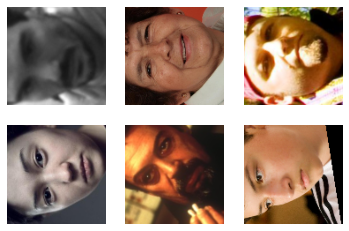

In [4]:
import numpy as np
import matplotlib.pyplot as plt

show_data = next(dataset.create_dict_iterator())

show_images = show_data["img"].asnumpy()
print(f'Image shape: {show_images.shape}')

plt.figure()

# 展示图片供参考
# TODO：多一点例图，然后中间和上下的空隙少一点
for i in range(1, 9):
    plt.subplot(2, 4, i)

    # 将图片转换HWC格式
    image_trans = np.transpose(show_images[i - 1], (2, 1, 0))
    image_trans = np.clip(image_trans, 0, 1)

    plt.imshow(image_trans[:, :, [2, 1, 0]])
    plt.axis("off")

## 构建网络

前文提到过PFLD模型的骨干网络采用了MobileNet网络，其中采用了大量的卷积层用于提取面部特征，由于人脸除了丰富的细节特征，还包含不同器官间之间的结构特征。所以，在主干网络的最后将多个尺度的特征结合起来以增强关键点的检测效果。

![pfld_structure](./images/pfld_structure.png)

TODO：加上对上图的解析。

### 骨干网络

主干网子网的详细配置为：

![network](images/network.png)

    > 说明：在原论文中，作者并没有明确定义骨干网络和检测器。为了更好的适应在不同的数据集上进行训练和迁移，本案例中将最后一层全连接层（TODO:S1,S2,S3）定义为检测器，之上的网络结构定义为骨干网络。

In [5]:
from mindspore import nn
from mindspore import ops

from mindvision.classification.models.blocks import ConvNormActivation
from mindvision.classification.models.backbones import InvertedResidual


class PFLDBackbone(nn.Cell):

    def __init__(self,
                 channel_num: tuple = (3, 64, 64, 64, 64, 128, 128, 128, 16, 32, 128)):
        super(PFLDBackbone, self).__init__()

        # Input channel, output channel, stride, expansion rate
        self.block1 = ConvNormActivation(channel_num[0], channel_num[1], 3, 2)
        self.block2 = ConvNormActivation(channel_num[1], channel_num[2], 3, 1)

        self.conv3 = InvertedResidual(channel_num[2], channel_num[3], 2, 2)
        self.block3 = self.make_layer(InvertedResidual, 4, channel_num[3], channel_num[4], 1, 2)

        self.conv4 = InvertedResidual(channel_num[4], channel_num[5], 2, 2)
        self.conv5 = nn.SequentialCell(
            ConvNormActivation(channel_num[5], channel_num[5] * 4, 1),
            ConvNormActivation(channel_num[5] * 4, channel_num[5] * 4),
            ConvNormActivation(channel_num[5] * 4, channel_num[6], 1, activation=None))
        self.block5 = self.make_layer(InvertedResidual, 5, channel_num[6], channel_num[7], 1, 4)

        self.conv6 = InvertedResidual(channel_num[7], channel_num[8], 1, 2)
        self.avg_pool1 = nn.AvgPool2d(14)

        self.conv7 = ConvNormActivation(channel_num[8], channel_num[9], 3, 2)
        self.avg_pool2 = nn.AvgPool2d(7)

        self.conv8 = nn.Conv2d(channel_num[9], channel_num[10], 7, 1, pad_mode="pad")
        self.relu = nn.ReLU()

        self.concat_op = ops.Concat(1)

    def make_layer(self,
                   block: nn.Cell,
                   layer_num: int,
                   in_channel: int,
                   out_channel: int,
                   stride: int,
                   expand_ratio: int):

        layers = []
        for _ in range(layer_num):
            pfld_aux_blk = block(in_channel, out_channel, stride, expand_ratio)
            layers.append(pfld_aux_blk)

        return nn.SequentialCell(layers)

    def construct(self, x):
        """ build network """
        x = self.block1(x)
        x = self.block2(x)
        x = self.conv3(x)
        features1 = self.block3(x)

        x = self.conv4(features1)
        x = self.conv5(x)
        x = self.block5(x)
        x = self.conv6(x)

        x1 = self.avg_pool1(x)
        x1 = x1.view((x1.shape[0], -1))

        x = self.conv7(x)
        x2 = self.avg_pool2(x)
        x2 = x2.view((x2.shape[0], -1))

        x3 = self.conv8(x)
        x3 = self.relu(x3)
        x3 = x3.view((x3.shape[0], -1))

        multi_scale = self.concat_op((x1, x2, x3))

        return features1, multi_scale

### 检测器

定义检测器的目的是为了更好的适应不同数量坐标点的情况。feature_num默认为176，如果使用0.25X版本需要改为44，具体计算方式可查看论文[1]。landmark_num常见取值为21，68，98，这主要取决于使用的数据集。

In [6]:
class LandmarkHead(nn.Cell):

    def __init__(self,
                 feature_num: int = 176,
                 landmark_num: int = 68):
        super(LandmarkHead, self).__init__()
        self.fc = nn.Dense(feature_num, landmark_num * 2)

    def construct(self, x):
        """ build network """
        landmark = self.fc(x)
        return landmark

### 辅助网络

TODO：还是没搞定辅助网络的输出是什么？可否增加详细的描述。

辅助网络是PFLD网络中一个非常重要的结构，前文提到人脸的器官结构信息是非常重要的，而该信息在头部发生扭动，俯仰等情况时，关键点会变形。此时，如果加入偏航角，俯仰角等信息会增强模型的预测能力。

辅助网络就负责预测头部姿势，包括偏航角、俯仰角和横滚角。

关于计算三个角度的方法如下：

1. 预定义一张标准人脸（在一堆正面中平均），并在主导人脸平面上固定11个界标作为所有训练人脸的参考。
2. 使用每个人脸的相应11个界标和参考界标来估计旋转矩阵。
3. 根据旋转矩阵计算欧拉角。

这个部分的操作在数据预处理中已经完成，具体可参考源码。

或许有人会感到奇怪，给定预测的和地面的地标，为什么不直接从它们计算出欧拉角呢？从技术上讲，这是可行的。然而，界标预测可能太不准确，尤其是在训练开始时，因此导致角度的低质量估计。这可能会使训练陷入困境，例如过度惩罚和缓慢收敛。为了使旋转信息的估计与地标定位分离，辅助子网应运而生。辅助网络的结构如图：

![AuxiliaryNet](images/auxiliarynet.png)


In [7]:
class AuxiliaryNet(nn.Cell):

    def __init__(self,
                 channel_num: tuple = (64, 128, 128, 32, 128, 32)):
        super(AuxiliaryNet, self).__init__()
        self.conv1 = ConvNormActivation(channel_num[0], channel_num[1], 3, 2)
        self.conv2 = ConvNormActivation(channel_num[1], channel_num[2], 3, 1)
        self.conv3 = ConvNormActivation(channel_num[2], channel_num[3], 3, 2)
        self.conv4 = ConvNormActivation(channel_num[3], channel_num[4], 2, 2)

        self.max_pool1 = nn.MaxPool2d(3, 2)
        self.fc1 = nn.Dense(channel_num[4], channel_num[5])
        self.fc2 = nn.Dense(channel_num[5], 3)

    def construct(self, x):
        """ build network """
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.max_pool1(x)
        x = x.view((x.shape[0], -1))
        x = self.fc1(x)
        x = self.fc2(x)
        return x

### 损失函数

训练的质量极大程度上取决于损失函数的设计，常用的$L_1$和$L_2$损失对于小规模训练数据不十分友好，给定两点在图像空间中的偏差，将两点的投影从3D真实面孔应用到2D图像，真实面孔的内在距离可能明显不同，因此将几何信息即偏航角、俯仰角和横滚角整合到惩罚中可缓解此问题。

另外，对于包含大量正面，而缺少姿势的较大的面孔的数据集，以此训练的模型不能处理大姿势改变的情况，自然地，针对不同姿势的样本设计不同的惩罚可以有效缓解数据不平衡问题。损失函数的一般形式如下：

$$
\mathcal{L} := \frac{1}{M} \sum_{m=1}^{M}\sum_{n=1}^{N}\gamma_n\lVert d_n^m \rVert
\tag{1}
$$

公式1中，$\lVert  . \rVert$指定一个度量来测量预测值与真实值的误差，我们使用$L_2$，$N$是每个面孔要检测的预定义坐标数量，$M$表示每个过程中训练图像的数量。权重$\gamma_n$是结合光照、模糊程度等信息和三个角度的综合考量，具体损失设计如下：

$$
\mathcal{L} := \frac{1}{M} \sum_{m=1}^{M}\sum_{n=1}^{N}\left ( \sum_{c=1}^{C}\omega_n^c\sum_{k=1}^{K}\left ( 1-cos \theta_n^k \right ) \right )\lVert d_n^m \rVert_2^2
\tag{2}
$$

公式2中，$\theta_1$，$\theta_2$，$\theta_3$表示真角与估计偏航角、俯仰角和横滚角之间的偏离角，随着偏差角增大，惩罚增加。另外，将样本分为多个属性类别，包括侧面、正面、仰头、低头、表情和遮挡等属性，使用加权参数$\omega_n^c$根据$c$类样本的分数进行调整。当然，如果不使用$\gamma_n$，我们的损失会退化为$L_2$损失。例如在使用WFLW数据集时，数据集中有各种属性的值，但是300W中就没有，我们使用的方法就是在300W数据集进行训练时将$\omega_n^c$置为1。

In [17]:
class PFLDLoss(nn.Cell):

    def __init__(self):
        super(PFLDLoss, self).__init__()
        self.sum = ops.ReduceSum(keep_dims=False)
        self.cos = ops.Cos()
        self.mean = ops.ReduceMean(keep_dims=False)

    # TODO：代码格式对齐
    def construct(
            self,
            angle,
            landmark,
            landmark_gt,
            weight_attribute,
            euler_angle_gt):
        """Constructing the forward calculation process."""
        weight_angle = self.sum(1 - self.cos(angle - euler_angle_gt), 1)
        l2_distant = self.sum((landmark_gt - landmark) *
                              (landmark_gt - landmark), 1)
        loss = weight_angle * weight_attribute * l2_distant
        return self.mean(loss)

## 模型实现

在之前的工作中，我们已经将300W数据集进行了训练集和测试集的划分、定义了网络结构，完成了针对不同数据进行不同程度惩罚的损失函数。在midspore中提供了训练的接口，但是直接使用此接口必须满足每条数据只有两列，例如一张图片和对应的类别等，的数据集不能满足此要求，因此在定义训练流程之前，需要自定义封装了损失函数和模型网络的类。

具体代码如下：

In [9]:
class CustomWithLossCell(nn.Cell):

    def __init__(self,
                 net: nn.Cell,
                 net_auxiliary: nn.Cell,
                 loss_fn: nn.Cell):
        super(CustomWithLossCell, self).__init__()
        self.net = net
        self.net_auxiliary = net_auxiliary
        self._loss_fn = loss_fn

    def construct(self, img, landmark_gt, weight_attribute, euler_angle):
        """ build network """
        feature1, landmark = self.net(img)
        angle = self.net_auxiliary(feature1)
        return self._loss_fn(angle,
                             landmark,
                             landmark_gt,
                             weight_attribute,
                             euler_angle)

### 模型训练

实例化损失函数，优化器，使用Model接口编译网络。本案例训练的是PFLD1X网络，论文中也提到了0.25X网络，其网络的每层参数为1X网络的四分之一。

In [ ]:
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig
from mindspore import Model
from mindvision.engine.callback import LossMonitor

from src.model.auxiliarynet import AuxiliaryNet
from src.model.losscell import CustomWithLossCell
from src.model.pfld import pfld_1x_68
from src.utils.loss import PFLDLoss


# 初始化模型结构
net_auxiliary = AuxiliaryNet()
net = pfld_1x_68()

# 计算学习率
dataset_size = len(dataset_generator.lines)
lr = nn.inverse_decay_lr(learning_rate=args.base_lr,
                         decay_rate=0.4,
                         total_step=(dataset_size // args.train_batchsize) * args.end_epoch,
                         step_per_epoch=dataset_size // args.train_batchsize,
                         decay_epoch=1)

# 优化器
optimizer = nn.Adam(params=net.get_parameters(),
                    learning_rate=lr,
                    weight_decay=1e-6)

# 自定义损失函数
loss = PFLDLoss()

# 联合损失函数的网络，适用于数据集中有多列的情况
net_with_loss = CustomWithLossCell(net, net_auxiliary, loss)

# 初始化模型
model = Model(network=net_with_loss, optimizer=optimizer)

# 设置ckpt文件保存的参数
config_ck = CheckpointConfig(save_checkpoint_steps=129,
                             keep_checkpoint_max=100)
ckpoint = ModelCheckpoint(prefix="checkpoint_300W",
                          directory='./checkpoint_300w',
                          config=config_ck)

# 训练
model.train(1, dataset, callbacks=[ckpoint, LossMonitor(lr)], dataset_sink_mode=False)

输出结果：

```text
Epoch:[ 1/40], step:[  0/129], loss:[6.709/6.732], time:418.097ms, lr:1.00010
Epoch:[ 1/40], step:[  1/129], loss:[6.739/6.739], time:417.928ms, lr:1.00010
Epoch:[ 1/40], step:[  2/129], loss:[6.729/6.734], time:418.322ms, lr:1.00010
......
Epoch:[40/40], step:[127/129], loss:[0.709/0.732], time:418.097ms, lr:0.00001
Epoch:[40/40], step:[128/129], loss:[0.739/0.739], time:417.928ms, lr:0.00001
Epoch:[40/40], step:[129/129], loss:[0.729/0.734], time:418.322ms, lr:0.00001
```

为了方便展示，案例中将epoch设置为1，经测试，在实际训练中，将epoch设置为100是一个不错的选择。

### 模型评估

在300W数据集的验证集上进行评估。

IPN（Inter-pupil Normalization）和ION（Inter-Ocular Normalization），以及NME（Normalization Mean Error）是人脸关键点的常用评价指标。

IPN和ION的计算公式一致:

$$
e_i = \frac{\left\| x_i - x_i^*\right\|_2}{d}
\tag{3}
$$

公式3中，$x_i$表示第 i 个关键点的预测坐标，$x_i^*$表示第 i 个关键点的 ground truth。

对于ION指标而言，d取值为左右眼角的距离。对于IPN指标而言，d取值为两瞳孔之间的距离（WFLW），如果没有瞳孔点（300W），取双眼区域12个关键点的平均距离。即用这些瞳孔距离的归一化值来表示预测结果与真实结果之间的差值，显然该值表明了预测的准确度，该值越小越好。

Normalization Mean Error 的计算公式为：

$$
e = \frac{\sum_{i=1}^{N}\left\| x_i - x_i^*\right\|_2}{N *d}
\tag{4}
$$

In [21]:
from mindvision.utils.load_pretrained_model import LoadPretrainedModel
from src.utils.metric import validate


# 初始化网络并将训练好的模型加载置网络中
net = pfld_1x_68()
LoadPretrainedModel(net, 'https://download.mindspore.cn/vision/pfld/PFLD1X_300W.ckpt').run()

# 加载评估所用的数据集
transform = vision.py_transforms.ToTensor()
dataset_generator = Datasets300W('./datasets/300W/test_data/list.txt', transform)
wlfw_dataset_val = ds.GeneratorDataset(list(dataset_generator),
                                       ["img", "landmark", "attributes", "angle"])
wlfw_dataset_val = wlfw_dataset_val.batch(batch_size=1,
                                          input_columns=["attributes"],
                                          output_columns=["weight_attribute"],
                                          per_batch_map=map_func)

# 验证模型效果
net.set_train(False)
validate(wlfw_dataset_val, net)

[WARNING] ME(11585:140224303310656,MainProcess):2022-06-24-23:01:18.907.312 [mindspore/train/serialization.py:660] For 'load_param_into_net', remove parameter net.backbone.block1.features.0.weight's prefix name: net., continue to load it to net parameter backbone.block1.features.0.weight.


=============== PFLD1X ==============
nme:0.0875
ion:0.7835
ipn:0.4350
inference_cost_time: 0.005290


TODO：对原论文中实验部分的表格要加解析。

![](images/mne.png)

### 模型推理

值得注意的是：

1. PFLD是人脸关键点检测的网络，重点在关键点检测上，网络的输入需要为人脸区域图像，作者在验证模型效果之前用到了mtcnn检测人脸区域，因此，推理的图片需要直接使用人脸图像。

2. 网络的输入为（1，3，112，112）的张量，本案例中的推理选择的是AFLW数据集中的一张处理后图片，若要使用其他大小的图片，请在输入网络前处理成网络可以推理的张量形式。

[WARNING] ME(11585:140224303310656,MainProcess):2022-06-24-23:03:41.943.858 [mindspore/train/serialization.py:660] For 'load_param_into_net', remove parameter net.backbone.block1.features.0.weight's prefix name: net., continue to load it to net parameter backbone.block1.features.0.weight.


(-0.5, 111.5, 111.5, -0.5)

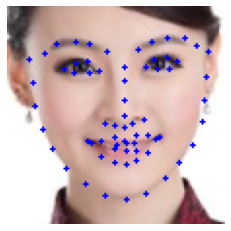

In [23]:
import cv2
from mindspore import Tensor


net = pfld_1x_68()
LoadPretrainedModel(net, 'https://download.mindspore.cn/vision/pfld/PFLD1X_300W.ckpt').run()

transform = vision.py_transforms.ToTensor()

# 读取图片
origin_img = cv2.imread('infer_image.png')
origin_h, origin_w, _ = origin_img.shape

# 将图片修正为（112，112）的尺寸并归一化
img = cv2.resize(origin_img, (112, 112))
img = transform(img)

# 网络输入为（1，3，112，112），对图片进行转换
img = np.expand_dims(img, axis=0)
img = Tensor(img)

# 得到预测的坐标点
_, landmarks = net(img)

# 处理坐标点及展示图片
landmarks = landmarks.asnumpy()
landmarks = landmarks.reshape(landmarks.shape[0], -1, 2)

pre_landmark = landmarks[0] * [origin_w, origin_h]

img_clone = cv2.imread("infer_image.png")
for (x, y) in pre_landmark.astype(np.int32):
    cv2.circle(img_clone, (x, y), 1, (255, 0, 0), -1)

plt.figure()
plt.imshow(img_clone[:, :, [2, 1, 0]])
plt.axis(False)

TODO：输出的(-0.5, 111.5, 111.5, -0.5)是什么意思吗？

## 流程与总结

![](images/data_flow.png)

本案例对PFLD的论文中提出的模型进行了详细的解释，向读者完整地展现了该算法的流程，分析了PFLD作者处理人脸检测问题中存在的挑战的思路等。

## 引用

[1] Guo X, Li S, Yu J, et al. PFLD: A practical facial landmark detector[J]. arXiv preprint arXiv:1902.10859, 2019.

[2] C. Sagonas, E. Antonakos, G, Tzimiropoulos, S. Zafeiriou, M. Pantic. 300 faces In-the-wild challenge: Database and results. Image and Vision Computing (IMAVIS), Special Issue on Facial Landmark Localisation "In-The-Wild". 2016.

[3] C. Sagonas, G. Tzimiropoulos, S. Zafeiriou, M. Pantic. 300 Faces in-the-Wild Challenge: The first facial landmark localization Challenge. Proceedings of IEEE Int’l Conf. on Computer Vision (ICCV-W), 300 Faces in-the-Wild Challenge (300-W). Sydney, Australia, December 2013.

[4] C. Sagonas, G. Tzimiropoulos, S. Zafeiriou, M. Pantic. A semi-automatic methodology for facial landmark annotation. Proceedings of IEEE Int’l Conf. Computer Vision and Pattern Recognition (CVPR-W), 5th Workshop on Analysis and Modeling of Faces and Gestures (AMFG 2013). Oregon, USA, June 2013.